In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
from typing import Callable, Optional, Tuple

import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
import numba

<IPython.core.display.Javascript object>

In [3]:
def rbf_kernel(
    x: np.ndarray, y: np.ndarray, sigma2: float = 1.0, ell: float = 1.0
) -> np.ndarray:
    """Vectorized rbf kernel"""
    return sigma2 * np.exp(-(((np.expand_dims(x, axis=1) - y) / ell) ** 2).sum(axis=2))


<IPython.core.display.Javascript object>

In [4]:
n_train = 10
x_train = np.random.uniform(low=-20, high=20, size=(n_train, 1))
y_train = np.random.normal(size=(n_train,))

<IPython.core.display.Javascript object>

In [5]:
class GPRegressor:
    """Perform regression using gaussian process with zero mean.

    Attributes
    ----------
    covar : np.ndarray
        The covariance matrix given by k(x_train, x_train) + I*eps.
    covar_inv : np.ndarray
        The inverse of `covar`.
    var_eps : float
        The variance noise gaussian noise $y_i = f_i + epsilon_i$, where
        epsilon_i ~ \mathcal{N}(0, var_eps)
    kernel : callable
        Vectorized kernel function to act as a proxy for covariances. Should give 0
        if inputs are extreme different and should rise as inputs become similar.
    kernel_kwargs : dict
        Extra keyword arguments to pass into the kernel.
    x_train : np.ndarray
        A D x N matrix with the training inputs.
    y_train: an N dimensional array with the training outputs.
    See:
    https://www.cs.cornell.edu/courses/cs4780/2018fa/lectures/lecturenote15.html
    """

    covar: np.ndarray
    covar_inv: np.ndarray
    var_eps: float
    kernel: callable
    kernel_kwargs: dict

    def __init__(
        self, var_eps: float, kernel: callable, kernel_kwargs: Optional[dict] = None
    ) -> None:
        """Set parameters for the class. See class docstring for arguments."""
        self.var_eps = var_eps
        self.kernel = kernel
        self.kernel_kwargs = kernel_kwargs or dict()

    def fit(self, x_train: np.ndarray, y_train: np.ndarray) -> None:
        """Make as many calculations as possible before inference time.
        Which is really calculating and setting `covar` and  `covar_inv`.
        """
        self.x_train = x_train
        self.y_train = y_train
        self.covar = (
            self.kernel(x_train, x_train, **self.kernel_kwargs)
            + np.eye(len(x_train)) * self.var_eps
        )
        self.covar_inv = np.linalg.inv(self.covar)

    def predict(self, x_star: np.array) -> Tuple[np.array, np.array]:
        """Find $p(f_star | x_train, y_train)$

        Parameters
        ----------
        x_start : np.array
            The inputs

        Returns
        -------
        mu_star : np.array
            The mean of f_star.
        covar_star : np.ndarray
            The covariance of f_star. Use the diag of this for variance of individual
            outputs.

        """
        # If the joint $p(f*, f)$ is gaussian, so is the conditional $p(f* | f)$.
        k_star = self.kernel(self.x_train, x_star, **self.kernel_kwargs)
        k_2star = (
            self.kernel(x_star, x_star, **self.kernel_kwargs)
            + np.eye(len(x_star)) * self.var_eps
        )
        mu_star = k_star.T @ self.covar_inv @ y_train
        covar_star = k_2star - k_star.T @ self.covar_inv @ k_star
        return mu_star, covar_star

<IPython.core.display.Javascript object>

In [6]:
kernel_kwargs = {"sigma2": 1, "ell": 3}
gp_regressor = GPRegressor(var_eps=00.1, kernel=rbf_kernel, kernel_kwargs=kernel_kwargs)
gp_regressor.fit(x_train, y_train)

x_test = np.linspace(-20, 20, 1000).reshape(-1, 1)
mu_star, covar_star = gp_regressor.predict(x_test)
sigma_star = np.diag(covar_star) ** 0.5

<IPython.core.display.Javascript object>

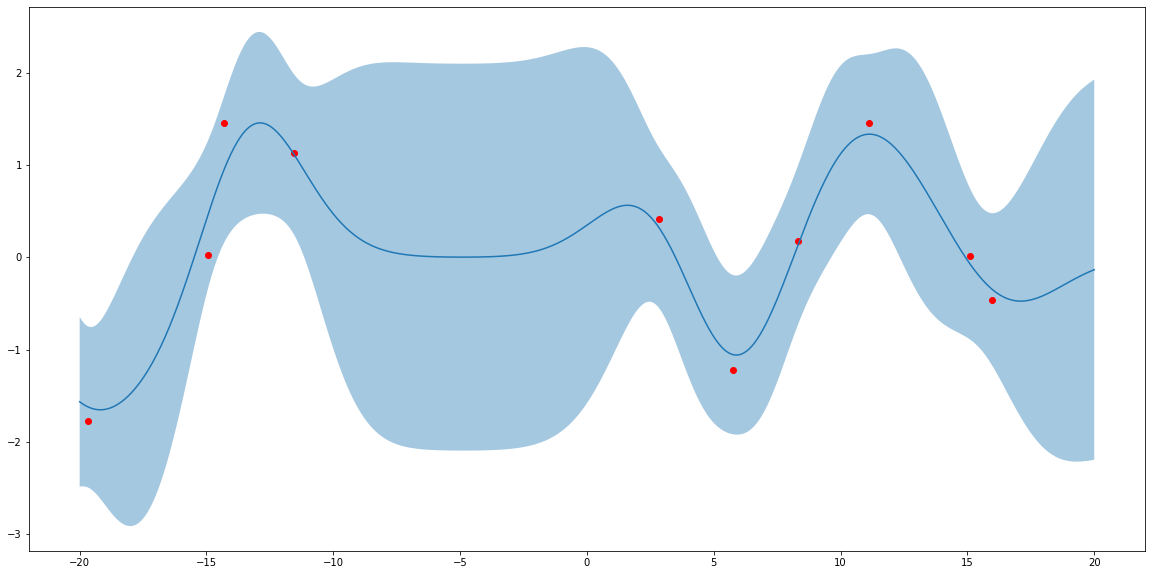

<IPython.core.display.Javascript object>

In [7]:
plt.figure(figsize=(20, 10))
plt.plot(x_train, y_train, "ro")
plt.plot(x_test, mu_star)
plt.fill_between(
    x_test.reshape(-1), mu_star + 2 * sigma_star, mu_star - 2 * sigma_star, alpha=0.4
)

# Gaussian Process for Binary Classification

In [8]:
Kernel = Callable[..., np.ndarray]


class GPClassifier:
    """Binary classification using Gaussian processes.

    Attributes
    ----------
    kernel: Kernel
        Vectorized kernel function.
    kernel_kwargs: dict
        Extra keyword arguments for the kernel function
    x_train: np.ndarray
        The trainign inputs.
    f_hat: np.ndarray
        The expected value of f at x_train
    w: np.ndarray
        The Hessian at the last iteration.
    """

    kernel: Kernel
    kernel_kwargs: dict
    x_train: np.ndarray
    f_hat: Optional[np.ndarray]
    w: Optional[np.ndarray]
    var_eps: float

    def __init__(
        self, kernel: Kernel, kernel_kwargs: Optional[dict] = None, var_eps: float = 1.0
    ) -> None:
        """Initialize the class."""
        self.kernel = kernel
        self.var_eps = var_eps
        self.kernel_kwargs = kernel_kwargs or {}

    def loss(
        self,
        y: np.ndarray,
        f: np.ndarray,
        x: np.ndarray,
        k_inv: Optional[np.ndarray] = None,
        det_k: Optional[float] = None,
        kernel: Optional[callable] = None,
        kernel_kwargs: Optional[dict] = None,
    ) -> float:
        """Calculate the unormalized -log posterior $p(f|y, X) \propto $p(f, y|X) = p(y|f, X) p(f|X)$.
        One of `k` or `kernel` must be given. If both are given, prefer `k`.

        Parameters
        ----------
        y : np.ndarray
            The noisy observations of f.
        f : np.ndarray
            The proposed values of the underlying function.
        x : np.ndarray
            The input data points
        sigma2y : float, optional
            The variance of the noise. By default 1.
        k : np.ndarray, optional
            The inverse of the Grahm matrix for x. By default None.
        det_k : np.ndarray, optional
            The determinant of the Grahm matrix for x. By default None.
        kernel : callable, optional
            Vectorized kernel function. By default None.
        kernel_kwargs : dict, optional
            Extra keyword arguments for the kernel. By default None.
        """
        if k_inv is None:
            k_inv = np.linalg.inv(self.kernel(x, x, **self.kernel_kwargs))

        if det_k is None:
            det_k = 1 / np.linalg.det(k_inv)

        loss = -self.log_sigmoid(y * f).sum()
        loss += 0.5 + f.reshape(1, -1) @ k_inv @ f
        loss += 0.5 * np.log(det_k)
        loss += len(x) / 2 * np.log(2 * np.pi)
        return loss

    @classmethod
    def grad_loss(cls, y: np.ndarray, f: np.ndarray, k_inv: np.ndarray) -> np.ndarray:
        """Compute the gradient for the loss function.

        Parameters
        ----------
        y : np.ndarray
            The noisy observations for f.
        f : np.ndarray
            The true function values.
        k_inv : np.ndarray
            The inverse of the Grahm matrix.
        """
        return (cls.sigmoid(f * y) - 1) * y + k_inv @ f

    @classmethod
    def hess_loss(cls, y: np.ndarray, f: np.ndarray, k_inv: np.ndarray) -> np.ndarray:
        """Compute  the hession of the loss.

        See `grad_loss` for parameters.
        """
        return -np.diag(cls.sigmoid(y * f) * (1 - cls.sigmoid(y * f))) + k_inv

    @staticmethod
    def sigmoid(x: np.ndarray) -> np.ndarray:
        """Numerically stable sigmoid function.
        Take advantage of the two formulas of the sigmoid function to avoid overflow errors.

        Parameters
        ----------
        x : np.ndarray

        Returns
        -------
        output : np.ndarray
        """
        positives = x >= 0
        negatives = np.logical_not(positives)
        output = np.zeros_like(x)
        output[positives] = 1 / (1 + np.exp(-x[positives]))
        output[negatives] = np.exp(x[negatives]) / (1 + np.exp(x[negatives]))
        return output

    @classmethod
    def log_sigmoid(cls, x: np.ndarray) -> np.ndarray:
        return np.log(self.sigmoid(x))

    def fit(
        self,
        x_train: np.ndarray,
        y_train: np.ndarray,
        n_iter: int = 101,
    ) -> None:
        """Fit model to data with IRLS.

        Parameters
        ----------
        x_train : np.ndarray
            The input matrix.
        y_train : np.ndarray
            Binary class labels in {-1, 1}.
        n_iter : int, optional
            The number of iterations. Defaults to 15.
        """
        self.x_train = x_train

        self.k = (
            self.kernel(x_train, x_train, **self.kernel_kwargs)
            + np.eye(len(x_train)) * self.var_eps
        )
        self.k_inv = np.linalg.inv(self.k)  # You're really not supposed to invert K

        f = np.random.rand(*y_train.shape)
        for _ in range(n_iter):
            grad = self.grad_loss(y_train, f, self.k_inv)
            hess = self.hess_loss(y_train, f, self.k_inv)
            f = f - np.linalg.inv(hess) @ grad  # Neither should you invert W
        self.f_hat = f
        self.w = hess

    def predict_mean(self, x_star: np.ndarray) -> np.ndarray:
        """Predict the mean value for new points.

        Parameters
        ----------
        x_star : np.ndarray
            The points in question.

        Returns
        -------
        The mean f for the new points.
        """
        k_star = self.kernel(x_star, x_train)
        return k_star @ self.k_inv @ self.f_hat

    def predict_var(self, x_star: np.ndarray) -> np.ndarray:
        """Calculate the predictive posterior variance.

        Parameters
        ----------
        x_star: np.ndarray
            The data for which to calculate the variance.

        Returns:
        np.ndarray
            The covariance matrix. Usually, you will only use the diagonal.


        """
        k_2star = (
            self.kernel(x_star, x_star, **self.kernel_kwargs)
            + np.eye(len(x_star)) * self.var_eps
        )
        k_star = self.kernel(x_star, self.x_train, **self.kernel_kwargs)
        return (
            k_2star
            - k_star @ self.k_inv @ k_star.T
            + k_star @ self.k_inv @ np.linalg.inv(self.k_inv + self.w) @ k_star.T
        )

<IPython.core.display.Javascript object>

In [9]:
x_train, y_train = datasets.make_blobs(
    n_samples=200, centers=np.array([[2, 1], [0, 0]])
)
y_train = y_train * 2 - 1

<IPython.core.display.Javascript object>

In [10]:
gp_classifier = GPClassifier(
    rbf_kernel,
    var_eps=0,
    kernel_kwargs={
        "ell": 0.6,
        "sigma2": 0.05,
    },  # These values can cause numerical instability
)

<IPython.core.display.Javascript object>

In [11]:
gp_classifier.fit(x_train, y_train, n_iter=400)

<IPython.core.display.Javascript object>

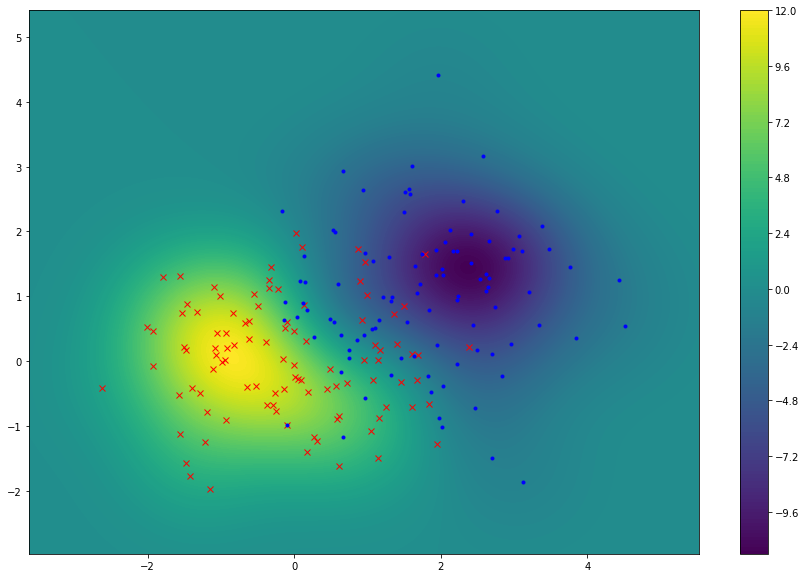

<IPython.core.display.Javascript object>

In [13]:
plt.figure(figsize=(15, 10))

xlist = np.linspace(x_train[:, 0].min() - 1, x_train[:, 0].max() + 1, 500)
ylist = np.linspace(x_train[:, 1].min() - 1, x_train[:, 1].max() + 1, 500)
X, Y = np.meshgrid(xlist, ylist)

x_star = np.array([X, Y]).reshape(2, -1).T
f_star = gp_classifier.predict_mean(x_star)

Z = f_star.reshape(500, 500)
cp = plt.contourf(X, Y, Z, levels=200)
plt.colorbar(cp)  # Add a colorbar to a plot
plt.plot(*x_train[y_train == 1].T, "rx")
plt.plot(*x_train[y_train == -1].T, "b.")
plt.show()


In [ ]:
plt.figure(figsize=(15, 10))

xlist = np.linspace(x_train[:, 0].min() - 1, x_train[:, 0].max() + 1, 1000)
ylist = np.linspace(x_train[:, 1].min() - 1, x_train[:, 1].max() + 1, 1000)
X, Y = np.meshgrid(xlist, ylist)

x_star = np.array([X, Y]).reshape(2, -1).T
f_var = np.diag(gp_classifier.predict_var(x_star))

Z = f_var.reshape(1000, 1000)
cp = plt.contourf(X, Y, Z, levels=80)
plt.colorbar(cp)  # Add a colorbar to a plot
plt.plot(*x_train[y_train == 1].T, "rx")
plt.plot(*x_train[y_train == -1].T, "b.")
plt.show()